
[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Training Data:  tensor([[-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
        [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
        [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
        ...,
        [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
        [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102],
        [-0.8102, -0.8102, -0.8102,  ..., -0.8102, -0.8102, -0.8102]])
Training Data Label:  tensor([9, 0, 0,  ..., 3, 0, 5])
Positive Data:  tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.8102, -0.8102, -0.8102],
        [ 1.0000,  0.0000,  0.0000,  ..., -0.8102, -0.8102, -0.8102],
        [ 1.0000,  0.0000,  0.0000,  ..., -0.8102, -0.8102, -0.8102],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.8102, -0.8102, -0.8102],
        [ 1.0000,  0.0000,  0.0000,  ..., -0.8102, -0.8102, -0.8102],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.8102, -0.8102, -0.8102]],
       device='cuda:0')
Negative Data:  tenso

100%|██████████| 200/200 [00:00<00:00, 259.56it/s]


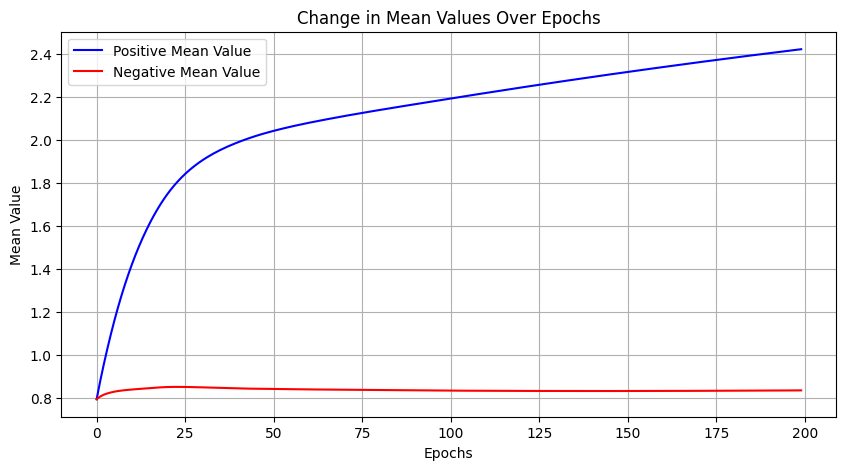

Training Layer 0 ...


100%|██████████| 200/200 [00:21<00:00,  9.22it/s]


Training Layer 1 ...


100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


Training Accuracy:  0.10000000149011612
Testing Accuracy:  0.09999999403953552


In [14]:
!pip install tqdm
!pip install matplotlib

import random

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda

import torch.nn as nn

from torch import Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam

number_of_epochs = 200

class Layer(nn.Linear):
    layer_weights = nn.Parameter(torch.ones(2, 1000).cuda())
    layer_weights_four = nn.Parameter(torch.ones(2, 1000).cuda())
    positive_hebbian_activity = nn.Parameter(torch.ones(1, 1).cuda())
    is_poly = 1
    negative_hebbian_activity = nn.Parameter(torch.ones(1, 1).cuda())
    

    def __init__(self, in_features, out_features, bias=True, device=None, d_type=None, is_hinge_loss=False):
        super().__init__(in_features, out_features, bias, device, d_type)
        self.activation = torch.nn.ReLU()
        self.learning_rate = 0.06
        self.optimizer = Adam(self.parameters(), lr=self.learning_rate)
        self.threshold = 2.0
        self.num_of_epochs = number_of_epochs
        self.is_hinge_loss = is_hinge_loss
        self.weight_optimizer = Adam([Layer.layer_weights, Layer.layer_weights_four], lr=0.15)


    def forward(self, input: Tensor) -> Tensor:
        normalized_input = input / (input.norm(2, 1, keepdim=True) + 1e-4)
        output = torch.mm(normalized_input, self.weight.T) + self.bias.unsqueeze(0)
        return self.activation(output)


    def balanced_loss(self, positive_goodness, negative_goodness, alpha=4.0):
        delta = positive_goodness - negative_goodness
        per_instance_loss = torch.log(1 + torch.exp(-alpha * delta))
        return per_instance_loss.mean()  


    def exponential_hinge_loss(self, positive_goodness, negative_goodness, delta=1.0, is_second_phase=False):
        if is_second_phase:
            threshold = self.threshold * 2
        else:
            threshold = self.threshold
        positive_loss = torch.exp(torch.clamp(delta - (positive_goodness - threshold), min=0)) - 1
        negative_loss = torch.exp(torch.clamp(delta - (threshold - negative_goodness), min=0)) - 1
        return torch.cat([positive_loss, negative_loss]).mean()


    def plot_goodness(self, positive_goodness_history, negative_goodness_history,
                      positive_unaltered_goodness_history, negative_unaltered_goodness_history):
        epochs = range(1, self.num_of_epochs + 1)

        plt.figure(figsize=(14, 7))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, positive_goodness_history, label='Altered Positive Goodness')
        plt.plot(epochs, positive_unaltered_goodness_history, label='Unaltered Positive Goodness')
        plt.legend()
        plt.title('Positive Goodness Comparison Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Goodness')

        plt.subplot(2, 1, 2)
        plt.plot(epochs, negative_goodness_history, label='Altered Negative Goodness')
        plt.plot(epochs, negative_unaltered_goodness_history, label='Unaltered Negative Goodness')
        plt.legend()
        plt.title('Negative Goodness Comparison Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Goodness')

        plt.tight_layout()
        plt.show()


    def train_layer(self, positive_input, negative_input, layer_num):
        for _ in tqdm(range(self.num_of_epochs)):
            positive_input = positive_input.detach().requires_grad_(True)
            negative_input = negative_input.detach().requires_grad_(True)
            positive_output = self.forward(positive_input)  # Shape: [batch_size, 500]
            negative_output = self.forward(negative_input)
            layer_weight_row = Layer.layer_weights[layer_num, :]
            layer_weight_four_row = Layer.layer_weights_four[layer_num, :]

            positive_goodness = (positive_output.pow(2) * layer_weight_row + positive_output.pow(4) * layer_weight_four_row).mean(1)  # Shape: [batch_size]
            negative_goodness = (negative_output.pow(2) * layer_weight_row + negative_output.pow(4) * layer_weight_four_row).mean(1)

            if self.is_hinge_loss:
                loss = self.exponential_hinge_loss(positive_goodness, negative_goodness)
            else:
                loss = self.balanced_loss(positive_goodness, negative_goodness)

            self.optimizer.zero_grad()
            self.weight_optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.weight_optimizer.step()
            
        return self.forward(positive_input).detach(), self.forward(negative_input).detach()


class Network(nn.Module):
    hebbian_weights = nn.Parameter(torch.ones(10, 774).cuda())
    def __init__(self, dimension_configs):
        super().__init__()
        self.layers = []
        self.hebbian_optimizer = Adam([Network.hebbian_weights], lr=0.002)
        for i in range(len(dimension_configs) - 1):
            self.layers += [Layer(dimension_configs[i], dimension_configs[i + 1]).cuda()]
            
    def balanced_loss(self, positive_goodness, negative_goodness, alpha=4.0):
        delta = positive_goodness - negative_goodness
        per_instance_loss = torch.log(1 + torch.exp(-alpha * delta))
        return per_instance_loss.mean()  

    def mark_data(self, data, label):
        marked_data = data.clone().cuda()
        marked_data[:, :10] = 0
        marked_data[torch.arange(marked_data.size(0)), label] = 1
        return marked_data
    
    
    def predict(self, input_data):
        goodness_per_label = []
        for label in range(10):
            marked_data = self.mark_data(input_data, label)
            hebb_activity = self.compute_hebbian_activity(marked_data).unsqueeze(1)
            marked_data = torch.cat((marked_data, hebb_activity), dim=1)
            goodness = []
            for layer_num, layer in enumerate(self.layers):
                marked_data = layer(marked_data)
                layer_weights = Layer.layer_weights[layer_num, :]
                layer_four_weights = Layer.layer_weights_four[layer_num, :]
                goodness_value = ((marked_data.pow(2) * layer_weights + marked_data.pow(4) * layer_four_weights * Layer.is_poly) * 1).mean(1)
                # goodness_value = marked_data.pow(2).mean(1)
                goodness.append(goodness_value)
            goodness_per_label.append(torch.sum(torch.stack(goodness), dim=0).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(dim=1)
    
    def compute_hebbian_activity(self, values):
        labels = values[:, :10].cuda()
        hebbian = values[:, 10:].cuda()
        hebbian_value = torch.mm(hebbian, self.hebbian_weights.T) * labels
        return hebbian_value.mean(1).cuda()
    
    
    def train_network(self, positive_goodness, negative_goodness):
        
        positive_mean_values = []
        negative_mean_values = []
        
        for _ in tqdm(range(number_of_epochs)):
            positive_labels = positive_goodness[:, :10].cuda()
            positive_hebbian = positive_goodness[:, 10:].cuda()
            positive_hebbian_value = torch.mm(positive_hebbian, self.hebbian_weights.T) * positive_labels
            positive_mean_value = positive_hebbian_value.mean(1).cuda()
            positive_mean_values.append(positive_mean_value.mean().item())  # Store average for plotting
        
            negative_labels = negative_goodness[:, :10].cuda()
            negative_hebbian = negative_goodness[:, 10:].cuda()
            negative_hebbian_value = torch.mm(negative_hebbian, self.hebbian_weights.T) * negative_labels
            negative_mean_value = negative_hebbian_value.mean(1).cuda()
            negative_mean_values.append(negative_mean_value.mean().item())  # Store average for plotting
        
            loss = self.balanced_loss(positive_mean_value, negative_mean_value)
            self.hebbian_optimizer.zero_grad()
            loss.backward()
            self.hebbian_optimizer.step()
        
        plt.figure(figsize=(10, 5))
        plt.plot(positive_mean_values, label='Positive Mean Value', color='blue')
        plt.plot(negative_mean_values, label='Negative Mean Value', color='red')
        plt.title('Change in Mean Values Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        positive_goodness = positive_goodness.detach()
        negative_goodness = negative_goodness.detach()
        Layer.positive_hebbian_activity = self.compute_hebbian_activity(positive_goodness)
        Layer.negative_hebbian_activity = self.compute_hebbian_activity(negative_goodness)
        
        
        
        Layer.positive_hebbian_activity = Layer.positive_hebbian_activity.unsqueeze(1)
        Layer.negative_hebbian_activity = Layer.negative_hebbian_activity.unsqueeze(1)


        goodness_pos, goodness_neg = positive_goodness, negative_goodness
        goodness_pos = torch.cat((goodness_pos, Layer.positive_hebbian_activity), dim=1)
        goodness_neg = torch.cat((goodness_neg, Layer.negative_hebbian_activity), dim=1)
        for i, layer in enumerate(self.layers):
            print('Training Layer', i, '...')
            goodness_pos, goodness_neg = layer.train_layer(goodness_pos, goodness_neg, i)
            


def load_CIFAR10_data(train_batch_size=30000, test_batch_size=6000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        CIFAR10('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        CIFAR10('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_FashionMNIST_data(train_batch_size=60000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.2860,), (0.3530,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        FashionMNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        FashionMNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_MNIST_data(train_batch_size=50000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader


def create_positive_data(data, label):
    positive_data = data.clone()
    positive_data[:, :10] = 0.0

    for i in range(positive_data.shape[0]):
        positive_data[i][label[i]] = 1.0

    return positive_data


def create_negative_data(data, label, seed=None):
    if seed is not None:
        random.seed(seed)

    negative_data = data.clone()
    negative_data[:, :10] = 0.0

    for i in range(negative_data.shape[0]):
        possible_answers = list(range(10))
        possible_answers.remove(label[i])
        false_label = random.choice(possible_answers)
        negative_data[i][false_label] = 1.0

    return negative_data


def prepare_data():
    torch.manual_seed(1234)
    training_data_loader, testing_data_loader = load_FashionMNIST_data()

    training_data, training_data_label = next(iter(training_data_loader))

    testing_data, testing_data_label = next(iter(testing_data_loader))
    testing_data, testing_data_label = testing_data.cuda(), testing_data_label.cuda()

    print(f"Training Data: ", training_data)
    print(f"Training Data Label: ", training_data_label)

    training_data, training_data_label = training_data.cuda(), training_data_label.cuda()

    positive_data = create_positive_data(training_data, training_data_label)
    print(f"Positive Data: ", positive_data)

    negative_data = create_negative_data(training_data, training_data_label, seed=1234)
    print(f"Negative Data: ", negative_data)

    return positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label


if __name__ == "__main__":
    torch.cuda.empty_cache()
    torch.manual_seed(1234)
    positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label = prepare_data()
    network = Network([785, 1000, 1000]).cuda() #3072
    network.train_network(positive_data, negative_data)

    print("Training Accuracy: ", network.predict(training_data).eq(training_data_label).float().mean().item())

    print("Testing Accuracy: ", network.predict(testing_data).eq(testing_data_label).float().mean().item())